https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [1]:
import pandas as pd
import numpy as np
df_update = pd.read_csv('/Users/jz/Downloads/job_data/2/df_update.csv', index_col=[0])
skill_cell = pd.read_csv('skill_cell.csv',header=None)

In [2]:
skill_cell.columns=['skill_list']
skill_cell.head()

,skill_list
0,"Python, SQL, R, Spark, Hive, AWS, Data Warehou..."
1,"SQL, R, Excel, Network"
2,"R, Excel"
3,"R, Microsoft Office, Excel, Marketing"
4,R


In [3]:
list_of_skill = skill_cell['skill_list'].to_list()

In [4]:
list_of_skill[:3]

['Python, SQL, R, Spark, Hive, AWS, Data Warehouse, Business Intelligence, Network',
 'SQL, R, Excel, Network',
 'R, Excel']

In [5]:
from nltk.tokenize import word_tokenize
example = list_of_skill
tokenized_sents = [word_tokenize(i) for i in example]

In [6]:
tokenized_sents

[['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Spark',
  ',',
  'Hive',
  ',',
  'AWS',
  ',',
  'Data',
  'Warehouse',
  ',',
  'Business',
  'Intelligence',
  ',',
  'Network'],
 ['SQL', ',', 'R', ',', 'Excel', ',', 'Network'],
 ['R', ',', 'Excel'],
 ['R', ',', 'Microsoft', 'Office', ',', 'Excel', ',', 'Marketing'],
 ['R'],
 ['R'],
 ['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Java',
  ',',
  'Tableau',
  ',',
  'AWS',
  ',',
  'Data',
  'Analysis',
  ',',
  'PostgreSQL',
  ',',
  'MySQL',
  ',',
  'S3',
  ',',
  'SaaS',
  ',',
  'SSH',
  ',',
  'Tomcat'],
 ['R', ',', 'Excel'],
 ['R', ',', 'Microsoft', 'Office', ',', 'Excel', ',', 'Go'],
 ['R'],
 ['SQL', ',', 'R', ',', 'Marketing', ',', 'CSS', ',', 'WordPress'],
 ['Software', 'Development', ',', '.Net', ',', 'C', '#', ',', 'SharePoint'],
 ['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Tableau',
  ',',
  'Linux',
  ',',
  'Go',
  ',',
  'CSS',
  ',',
  'GIS',
  ',',
  'Google',
  'Analytics',
  ',',
  'Omniture',
  ',',

In [7]:
for row in tokenized_sents:
    for i in row:
        if i == ',':
            row.remove(i)

In [8]:
tokenized_sents[:10]

[['Python',
  'SQL',
  'R',
  'Spark',
  'Hive',
  'AWS',
  'Data',
  'Warehouse',
  'Business',
  'Intelligence',
  'Network'],
 ['SQL', 'R', 'Excel', 'Network'],
 ['R', 'Excel'],
 ['R', 'Microsoft', 'Office', 'Excel', 'Marketing'],
 ['R'],
 ['R'],
 ['Python',
  'SQL',
  'R',
  'Java',
  'Tableau',
  'AWS',
  'Data',
  'Analysis',
  'PostgreSQL',
  'MySQL',
  'S3',
  'SaaS',
  'SSH',
  'Tomcat'],
 ['R', 'Excel'],
 ['R', 'Microsoft', 'Office', 'Excel', 'Go'],
 ['R']]

In [9]:
data_ready = tokenized_sents

In [11]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.156*"R" + 0.147*"Excel" + 0.106*"Go" + 0.097*"Microsoft" + 0.082*"Office" '
  '+ 0.080*"Marketing" + 0.035*"CI" + 0.029*"UI" + 0.028*"SharePoint" + '
  '0.021*"SAP"'),
 (1,
  '0.250*"R" + 0.177*"Excel" + 0.099*"Management" + 0.098*"SQL" + '
  '0.060*"Visio" + 0.050*"Accounting" + 0.041*"Project" + 0.037*"SAS" + '
  '0.018*"Software" + 0.016*"Development"'),
 (2,
  '0.167*"SQL" + 0.154*"Tableau" + 0.093*"Python" + 0.080*"R" + 0.036*"Azure" '
  '+ 0.035*"Oracle" + 0.029*"Java" + 0.027*"SaaS" + 0.026*"C" + 0.026*"#"'),
 (3,
  '0.166*"Business" + 0.105*"Intelligence" + 0.097*"Data" + 0.079*"AI" + '
  '0.065*"R" + 0.057*"Analysis" + 0.051*"Power" + 0.051*"BI" + 0.033*"Jira" + '
  '0.024*"Science"')]


In [13]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4676,"Business, Intelligence, Data, AI, R, Analysis,...","[Python, SQL, R, Spark, Hive, AWS, Data, Wareh..."
1,1,1.0,0.8467,"R, Excel, Management, SQL, Visio, Accounting, ...","[SQL, R, Excel, Network]"
2,2,1.0,0.7431,"R, Excel, Management, SQL, Visio, Accounting, ...","[R, Excel]"
3,3,0.0,0.8728,"R, Excel, Go, Microsoft, Office, Marketing, CI...","[R, Microsoft, Office, Excel, Marketing]"
4,4,1.0,0.6117,"R, Excel, Management, SQL, Visio, Accounting, ...",[R]
5,5,1.0,0.6117,"R, Excel, Management, SQL, Visio, Accounting, ...",[R]
6,6,2.0,0.7868,"SQL, Tableau, Python, R, Azure, Oracle, Java, ...","[Python, SQL, R, Java, Tableau, AWS, Data, Ana..."
7,7,1.0,0.7431,"R, Excel, Management, SQL, Visio, Accounting, ...","[R, Excel]"
8,8,0.0,0.8728,"R, Excel, Go, Microsoft, Office, Marketing, CI...","[R, Microsoft, Office, Excel, Go]"
9,9,1.0,0.6117,"R, Excel, Management, SQL, Visio, Accounting, ...",[R]


In [14]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9051,"R, Excel, Go, Microsoft, Office, Marketing, CI, UI, SharePoint, SAP","[R, Microsoft, Office, Excel, SAP, CI, Payroll]"
1,1.0,0.9051,"R, Excel, Management, SQL, Visio, Accounting, Project, SAS, Software, Development","[SQL, R, Excel, Visio, PMP, Windows, ICD-9]"
2,2.0,0.9308,"SQL, Tableau, Python, R, Azure, Oracle, Java, SaaS, C, #","[Python, SQL, R, Java, Tableau, Git, JSON, Alteryx, PL/SQL, React]"
3,3.0,0.8897,"Business, Intelligence, Data, AI, R, Analysis, Power, BI, Jira, Science","[R, Data, Science, Business, Intelligence, Epic]"


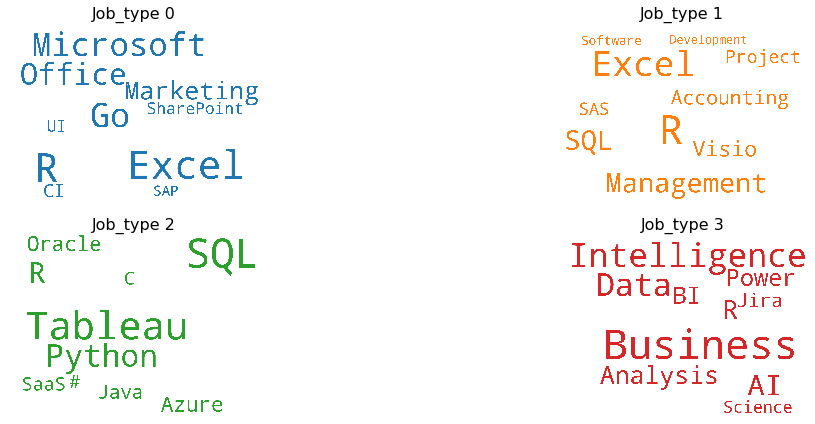

In [15]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Job_type ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

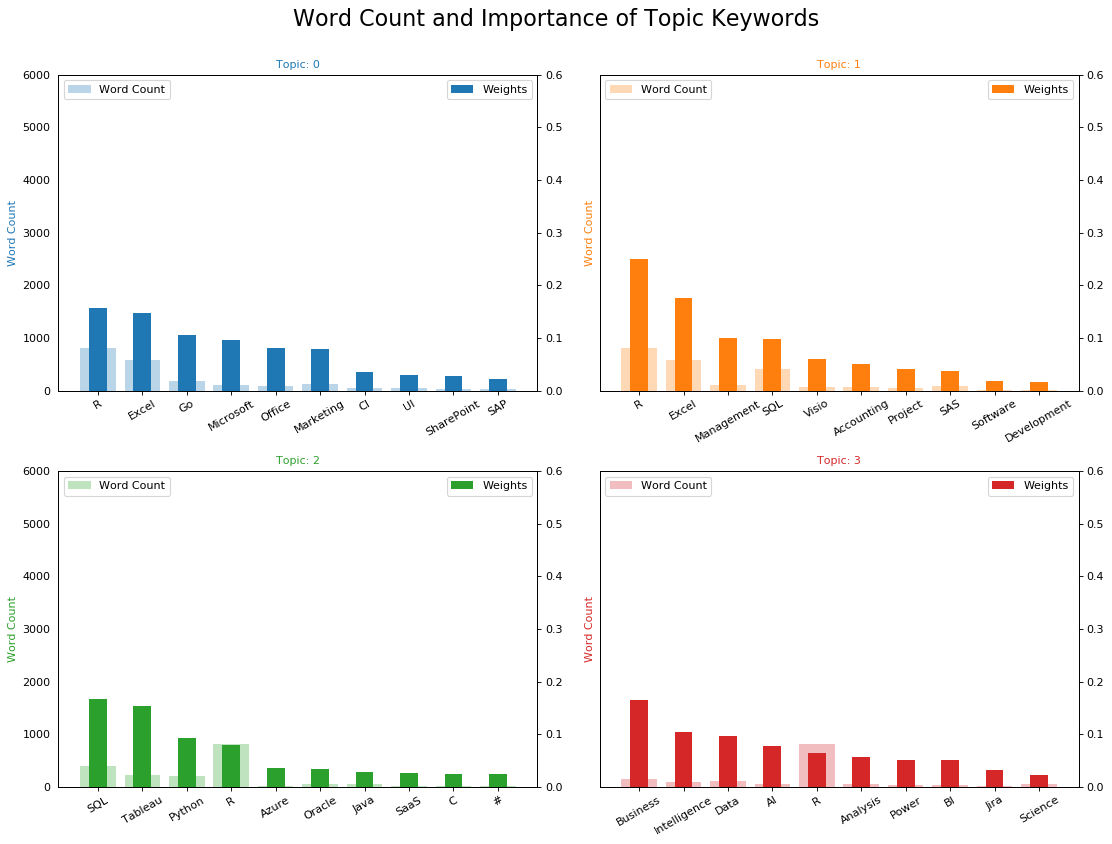

In [17]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.8, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.4, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.6); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)    
plt.show()

In [18]:
df.to_csv('df_topic.csv')

In [19]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

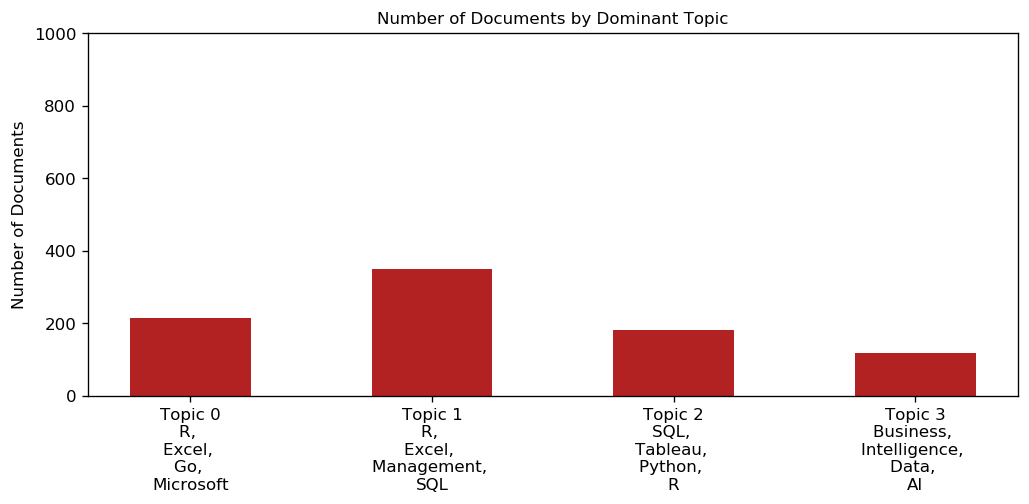

In [20]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

plt.show()

In [21]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=1200, plot_height=600)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 840 samples in 0.000s...
[t-SNE] Computed neighbors for 840 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 840 / 840
[t-SNE] Mean sigma: 0.000264
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.555099
[t-SNE] KL divergence after 1000 iterations: 0.334885


Loading BokehJS ...

In [22]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.054137  0.313666       1        1  27.577709
1     -0.154610 -0.033182       2        1  27.065750
0     -0.152178 -0.220393       3        1  25.650537
3      0.360925 -0.060091       4        1  19.706005, topic_info=    Category        Freq           Term       Total  loglift  logprob
11   Default  448.000000          Excel  448.000000  30.0000  30.0000
22   Default  223.000000        Tableau  223.000000  29.0000  29.0000
1    Default  172.000000       Business  172.000000  28.0000  28.0000
8    Default  381.000000            SQL  381.000000  27.0000  27.0000
24   Default  143.000000             Go  143.000000  26.0000  26.0000
44   Default  141.000000     Management  141.000000  25.0000  25.0000
4    Default  109.000000   Intelligence  109.000000  24.0000  24.0000
13   Default  131.000000      Microsoft  131.000000  23.0000  23.0000
6    Default  135.000000         Python  135.000000  22.0000  22.0000
2    Default  100.000000           Data  100.000000  21.0000  21.0000
14   Default  110.000000         Office  110.000000  20.0000  20.0000
12   Default  107.000000      Marketing  107.000000  19.0000  19.0000
53   Default   82.000000             AI   82.000000  18.0000  18.0000
55   Default   85.000000          Visio   85.000000  17.0000  17.0000
15   Default   59.000000       Analysis   59.000000  16.0000  16.0000
43   Default   71.000000     Accounting   71.000000  15.0000  15.0000
101  Default   54.000000          Power   54.000000  14.0000  14.0000
98   Default   54.000000             BI   54.000000  13.0000  13.0000
7    Default  748.000000              R  748.000000  12.0000  12.0000
45   Default   59.000000        Project   59.000000  11.0000  11.0000
40   Default   53.000000            SAS   53.000000  10.0000  10.0000
107  Default   52.000000          Azure   52.000000   9.0000   9.0000
79   Default   51.000000         Oracle   51.000000   8.0000   8.0000
51   Default   48.000000             CI   48.000000   7.0000   7.0000
80   Default   34.000000           Jira   34.000000   6.0000   6.0000
16   Default   42.000000           Java   42.000000   5.0000   5.0000
56   Default   39.000000             UI   39.000000   4.0000   4.0000
31   Default   38.000000     SharePoint   38.000000   3.0000   3.0000
21   Default   39.000000           SaaS   39.000000   2.0000   2.0000
27   Default   37.000000              #   37.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
53    Topic4   81.347832             AI   82.160248   1.6143  -2.5432
15    Topic4   59.230324       Analysis   59.979412   1.6117  -2.8605
101   Topic4   53.286938          Power   54.052433   1.6100  -2.9662
98    Topic4   53.286938             BI   54.052433   1.6100  -2.9662
80    Topic4   33.664707           Jira   34.447971   1.6012  -3.4255
41    Topic4   24.371508        Science   25.123550   1.5939  -3.7485
42    Topic4   23.724791           SDLC   24.545311   1.5902  -3.7754
73    Topic4   19.651455            Big   20.459467   1.5840  -3.9638
61    Topic4   20.117401           Perl   21.012516   1.5807  -3.9403
10    Topic4   16.631603      Warehouse   17.416563   1.5781  -4.1306
9     Topic4   15.153976          Spark   15.988475   1.5706  -4.2237
60    Topic4   13.104423           Epic   13.944442   1.5621  -4.3690
76    Topic4   10.946383        Machine   11.696275   1.5580  -4.5489
75    Topic4   10.946383       Learning   11.696275   1.5580  -4.5489
201   Topic4    6.881774           LDAP    7.616123   1.5229  -5.0131
202   Topic4    6.881774       Selenium    7.616123   1.5229  -5.0131
175   Topic4    9.822705       QlikView   10.880288   1.5220  -4.6572
151   Topic4    6.305392     Regulatory    7.053411   1.5121  -5.1005
152   Topic4    6.305392      Reporting    7.053411   1.5121  -5.1005
127   Topic4    7.291914     Confluence    8.190961   1.5080  -

In [23]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
pyLDAvis.save_html(p, 'lda.html')

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
